## Driver code generating brain-maps

### Steps
- import stat csvs 
- visualize quantitative performance  
- visualize brain regions

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import itertools
import pickle
import time
from scipy.spatial import distance
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

import nibabel as nib
from surfer import Brain
from mayavi import mlab

# from tvtk.api import tvtk
# from tvtk.common import configure_input_data

mlab.init_notebook()
mlab.options.offscreen = True

%matplotlib inline

#%env SUBJECTS_DIR=/home/nikhil/projects/CT_reproduce/data/fs_output/subjects
%env SUBJECTS_DIR=/home/nikhil/projects/CT_reproduce/code/compare-surf-tools/config

sys.path.append('../')
from lib.plot_utils import *
from lib.data_stats import aggregate_perf

Notebook initialized with x3d backend.
env: SUBJECTS_DIR=/home/nikhil/projects/CT_reproduce/code/compare-surf-tools/config


### Brainmap plot configs

In [3]:
analysis_type = 'sm' #sm or ml
results_type = 'atlas' # atlas or software

### Global Vars

In [4]:
subject_ID_col = 'SubjID'

### Data paths

In [5]:
proj_dir = '/home/nikhil/projects/CT_reproduce/'
data_dir = proj_dir + 'code/compare-surf-tools/data/'
results_dir = proj_dir + 'data/results/'
stat_results_dir = results_dir + 'sm2/{}/'.format(results_type)
brainmaps_dir = stat_results_dir + 'brainmaps_3/'

common_space = proj_dir + 'code/compare-surf-tools/config/fsaverage/'
demograph_file = 'ABIDE_Phenotype.csv'


# Demographics and Dx
demograph = pd.read_csv(data_dir + demograph_file)
demograph = demograph.rename(columns={'Subject_ID':subject_ID_col})

outcome_var = 'roi' #'DX_GROUP'
predictor_var = 'AGE_AT_SCAN' #'DX_GROUP'
stat_measure = 'p_val_corr' # p_val or p_val_corr
stat_thresh = 0.05

if outcome_var == 'DX_GROUP':
    model_type = 'logit'
elif outcome_var in ['AGE_AT_SCAN','roi']:
    model_type = 'ols'
else:
    print('Unknown outcome variable {}'.format(outcome_var))

qc_list = ['No_QC','gleb','maarten','auto_low_dim','auto_high_dim']

if results_type == 'software':
    stat_perf_qc_concat = pd.DataFrame()
else:
    stat_perf_qc_concat = {}
    
for qc_type in qc_list:
    #pipelines_sm_perf_DKT_test_AGE_AT_SCAN_roi_ols_QC_manual_maarten_N_748.pkl
    if results_type == 'software':
        if qc_type == 'auto_low_dim':
            sm_perf_file = 'Software_DKT_sm_perf_{}_{}_{}_QC_auto_low_dim_N_683.pkl'.format(outcome_var,predictor_var,model_type)
        elif qc_type == 'auto_high_dim':
            sm_perf_file = 'Software_DKT_sm_perf_{}_{}_{}_QC_auto_high_dim_N_662.pkl'.format(outcome_var,predictor_var,model_type)
        elif qc_type == 'maarten':
            sm_perf_file = 'Software_DKT_sm_perf_{}_{}_{}_QC_manual_lenient_N_748.pkl'.format(outcome_var,predictor_var,model_type)
        elif qc_type == 'gleb':
            sm_perf_file = 'Software_DKT_sm_perf_{}_{}_{}_QC_manual_stringent_N_194.pkl'.format(outcome_var,predictor_var,model_type)
        else:
            sm_perf_file = 'Software_DKT_sm_perf_{}_{}_{}_QC_No_QC_N_778.pkl'.format(outcome_var,predictor_var,model_type)

    else: 
        if qc_type == 'auto_low_dim':
            sm_perf_file = 'Atlas_FS6.0_sm_perf_{}_{}_{}_QC_auto_low_dim_N_959.pkl'.format(outcome_var,predictor_var,model_type)
        if qc_type == 'auto_high_dim':
            sm_perf_file = 'Atlas_FS6.0_sm_perf_{}_{}_{}_QC_auto_high_dim_N_908.pkl'.format(outcome_var,predictor_var,model_type)   
        elif qc_type == 'maarten':
            sm_perf_file = 'Atlas_FS6.0_sm_perf_{}_{}_{}_QC_manual_lenient_N_975.pkl'.format(outcome_var,predictor_var,model_type)
        elif qc_type == 'gleb':
            sm_perf_file = 'Atlas_FS6.0_sm_perf_{}_{}_{}_QC_manual_stringent_N_225.pkl'.format(outcome_var,predictor_var,model_type)
        else:
            sm_perf_file = 'Atlas_FS6.0_sm_perf_{}_{}_{}_QC_No_QC_N_1047.pkl'.format(outcome_var,predictor_var,model_type)


    print('\nUsing following configs: \n outcome variable: {}\n predictor var: {}\n results_type: {}\n model_type: {}\n qc_type: {}\n'.format(outcome_var,
                                                                                                                        predictor_var,
                                                                                                                        results_type,
                                                                                                                        model_type,
                                                                                                                        qc_type))
    print('Perf file used: {}'.format(sm_perf_file))

    if stat_measure == 'p_val':
        mult_comp = 'no_FDR'
    elif stat_measure == 'p_val_corr':
        mult_comp = 'FDR'
    else:
        print('unknown multiple comparison correction')
        mult_comp = 'unknown'


    sm_perf_filename_split = sm_perf_file.rsplit('.',1)[0].rsplit('_',2) 
    #brainmap_subdir_prefix = sm_perf_filename_split[0] + '_{}_'.format(mult_comp) + sm_perf_filename_split[1] + '_' + sm_perf_filename_split[2] + '/'
    brainmap_subdir_prefix = '{}_{}_{}_{}/'.format(results_type,predictor_var,model_type,stat_measure)

    if results_type == 'software':
        stat_perf = pd.read_pickle(stat_results_dir + sm_perf_file)
        stat_perf['qc'] = qc_type
        stat_perf_qc_concat = stat_perf_qc_concat.append(stat_perf)

    else:
        with open(stat_results_dir + sm_perf_file, 'rb') as handle:
            stat_perf = pickle.load(handle)
    
        #stat_perf['qc'] = qc_type
        stat_perf_qc_concat[qc_type] = stat_perf


Using following configs: 
 outcome variable: roi
 predictor var: AGE_AT_SCAN
 results_type: atlas
 model_type: ols
 qc_type: No_QC

Perf file used: Atlas_FS6.0_sm_perf_roi_AGE_AT_SCAN_ols_QC_No_QC_N_1047.pkl

Using following configs: 
 outcome variable: roi
 predictor var: AGE_AT_SCAN
 results_type: atlas
 model_type: ols
 qc_type: gleb

Perf file used: Atlas_FS6.0_sm_perf_roi_AGE_AT_SCAN_ols_QC_manual_stringent_N_225.pkl

Using following configs: 
 outcome variable: roi
 predictor var: AGE_AT_SCAN
 results_type: atlas
 model_type: ols
 qc_type: maarten

Perf file used: Atlas_FS6.0_sm_perf_roi_AGE_AT_SCAN_ols_QC_manual_lenient_N_975.pkl

Using following configs: 
 outcome variable: roi
 predictor var: AGE_AT_SCAN
 results_type: atlas
 model_type: ols
 qc_type: auto_low_dim

Perf file used: Atlas_FS6.0_sm_perf_roi_AGE_AT_SCAN_ols_QC_No_QC_N_1047.pkl

Using following configs: 
 outcome variable: roi
 predictor var: AGE_AT_SCAN
 results_type: atlas
 model_type: ols
 qc_type: auto_high_di

## PySurfer plots

In [6]:
# Plot configs

if results_type == 'software':
    softwares = list(stat_perf_qc_concat['software'].unique())
    qc_list = list(stat_perf_qc_concat['qc'].unique())
    aparcs = ['DKT']
    aparc = 'DKT'
    aparc_file = '.aparc.DKTatlas40.annot'
else:
    softwares = ['FS60']
    software = 'FS60' #For aggregating result cell 
    qc_list = list(stat_perf_qc_concat.keys())
    aparcs = list(stat_perf.keys()) #['aparc', 'Destrieux', 'Glasser']
    
# Pysurfer parameters
surf = 'inflated' #'white' #"inflated"
views = ['lateral','medial']

In [7]:
def create_surface_plot2(common_space,hemi,surf,aparc_file,signific_rois,save_dir,title,view,signifcance_color=[],plot_style={}):
    """
    Creates a pysurfer brain, overlays surface parcellation, and colormaps given ROIs 
    Used for plotting signficant ROIs
    If significance color (effect size / betas) are provided (in the same order as significant ROIs) then uses it as a colormap
    """
    brain = Brain(common_space, hemi, surf, background="white",title=title,views=view)

    if len(signific_rois) > 0:
        aparc_file_path = os.path.join(os.environ["SUBJECTS_DIR"],
                                common_space, "label",
                                hemi + aparc_file)
        labels, ctab, names = nib.freesurfer.read_annot(aparc_file_path)

        print('number of total vertices {} and ROIs {}'.format(len(labels),len(names)))
        
        # Convert names from bytes to strings
        names = [n.decode("utf-8").replace('-','_') for n in names]
            
        idx = []
        for roi in signific_rois:
            idx.append(names.index(roi))

        #print('idx-betas \n{} \n{}'.format(list(zip(idx,signifcance_color)), np.array(names)[idx]))
        roi_value = np.zeros(len(names)) #np.random.randint(5, size=len(names)) #np.zeros(len(names))
        if len(signifcance_color) == 0:
            roi_value[idx] = np.arange(2,len(idx)+2) #random signifcance_color
        else:
            roi_value[idx] = signifcance_color
            print('Using betas as colormap')

        print('number of significant rois {}'.format(len(signific_rois)))
            
        vtx_data = roi_value[labels]
            
        #Handle vertices that are not defined in the annotation.
        vtx_data[labels == -1] = 0

        unique, counts = np.unique(vtx_data, return_counts=True)
        print('atlas: {}, signficant roi count: {}'.format(aparc_file, dict(zip(unique, counts))))

        #plot style and aesthetic
        if 'colormap' in plot_style.keys():
            colormap = plot_style['colormap']
        else:
            colormap = 'icefire'

        if 'center' in plot_style.keys():
            c_center = plot_style['center']
            brain.add_data(vtx_data,colormap=colormap, alpha=0.9, colorbar=True, center=c_center)
        elif 'range' in plot_style.keys():
            c_min = plot_style['range'][0]
            c_max = plot_style['range'][1]
            brain.add_data(vtx_data,colormap=colormap, alpha=0.9, colorbar=True, min=c_min,max=c_max)
        else:
            brain.add_data(vtx_data,colormap=colormap, alpha=0.9, colorbar=True)

        
        
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    save_path = '{}surf{}.png'.format(save_dir,title)
    brain.save_image(save_path)
    print('Image saved at {}'.format(save_path))

In [8]:
# Plot loops 
plot_metric = 'betas'

n_colors = 10
cmap = plt.get_cmap('copper',n_colors)
# cmap = ['#fee0d2', '#fc9272', '#de2d26']
#plot_style = {'colormap':cmap,'range':[0,n_colors-1]}
plot_style = {'colormap':'PiYG_r','center':0} #'BrBG_r

for software in softwares:
    for aparc in aparcs:
        for qc in qc_list:
            if results_type == 'software':            
                stat_df = stat_perf_qc_concat[(stat_perf_qc_concat['software']==software)&
                                              (stat_perf_qc_concat['qc']==qc)].copy()
                
            else:
                stat_perf = stat_perf_qc_concat[qc]
                stat_df = stat_perf[aparc]

            print('stat_df shape {}'.format(stat_df.shape))
            
           
   
            if plot_metric == 'categorical_betas':
                print('plotting categorical (signficant or not significant) betas')
                signific_rois = stat_df[stat_df[stat_measure] < stat_thresh]['roi'].values
                non_signific_rois = stat_df[stat_df[stat_measure] >= stat_thresh]['roi'].values

                signific_betas = 1*np.ones(len(signific_rois)) ### Only coloring significant rois 
                non_signific_betas = 2*np.ones(len(non_signific_rois)) ### Only coloring significant rois 
                
                #### Trying out coloring both signific and non-signific with different colors than background
                plot_rois = list(signific_rois) + list(non_signific_rois)
                plot_betas = list(signific_betas)+ list(non_signific_betas)
    
            elif plot_metric == 'betas':
                print('plotting beta-scores')
                plot_rois = stat_df['roi'].values
                plot_betas = stat_df['coef'].values 
                
                
            elif plot_metric == 'zscores':
                print('plotting z-scores')
                plot_rois = stat_df['roi'].values
                coef = stat_df['coef'].values 
                plot_betas = stats.zscore(coef)
                
            else:
                print('unknow beta plotting category')
            
        
            print('\nPipeline {}, parcellation {}, number of signficant ROIs {}'.format(software, aparc,len(plot_rois)))

            plot_regions_L,plot_regions_R,betas_L,betas_R = get_pysurfer_label_format(plot_rois,aparc,plot_betas)
        
            if aparc == 'Glasser':
                aparc_file = '.HCP-MMP1.annot' 
            elif aparc == 'Destrieux':
                aparc_file = '.aparc.a2009s.annot' 
            elif aparc == 'aparc':
                aparc_file = '.aparc.annot'
            elif aparc in 'DKT':
                aparc_file = '.aparc.DKTatlas40.annot'
            else:
                aparc_file = ''
                print('Unknown cortical parcellation')

                
            save_dir = brainmaps_dir + brainmap_subdir_prefix + '{}_{}_{}/'.format(software, aparc,qc)
            for hemi in ['lh', 'rh']:
                if hemi=='lh':
                    plot_rois = plot_regions_L
                    betas = betas_L
                elif hemi=='rh':
                    plot_rois = plot_regions_R
                    betas = betas_R
                else: 
                    print('Unknown hemisphere parameter')

                for view in views:
                    title = '_{}_{}_{}_{}_{}_{}'.format(software,aparc,surf,hemi,view,stat_measure)
                    brain_fig = create_surface_plot2(common_space,hemi,surf,aparc_file,plot_rois,
                                                    save_dir,title,view,betas,plot_style)
                    time.sleep(5) #Mayavi messes up if called to quickly


stat_df shape (63, 5)
plotting beta-scores

Pipeline FS60, parcellation DKT, number of signficant ROIs 63
number of total vertices 163842 and ROIs 36
Using betas as colormap
number of significant rois 31
atlas: .aparc.DKTatlas40.annot, signficant roi count: {-0.014323226074852377: 12671, -0.013675633048371532: 3856, -0.013592106466168055: 5191, -0.013331093502647457: 7186, -0.013289302829067904: 7442, -0.012748203505738067: 2373, -0.012286020843505335: 8593, -0.012034160436600327: 4115, -0.011850738655829857: 1286, -0.011521509439911709: 8421, -0.011481962512795816: 1030, -0.011349667129644058: 2423, -0.011093514731827034: 3875, -0.010747137261043703: 2524, -0.009962597749547952: 4204, -0.009681607401940606: 10696, -0.009322747016904179: 1893, -0.009167046994051044: 2118, -0.009070670081639432: 6108, -0.008896157219193311: 2316, -0.008618359659425293: 3317, -0.008567084741227209: 4643, -0.008267547644268111: 2838, -0.008245486375844923: 4791, -0.007999891849129716: 4311, -0.00687172292

Image saved at /home/nikhil/projects/CT_reproduce/data/results/sm2/atlas/brainmaps_3/atlas_AGE_AT_SCAN_ols_p_val_corr/FS60_DKT_gleb/surf_FS60_DKT_inflated_rh_lateral_p_val_corr.png
number of total vertices 163842 and ROIs 36
Using betas as colormap
number of significant rois 32
atlas: .aparc.DKTatlas40.annot, signficant roi count: {-0.022202718413202212: 1279, -0.019293129313053044: 4679, -0.019132783742399337: 5320, -0.016806245938367576: 770, -0.016693631242542847: 14669, -0.016057773896574104: 3943, -0.015448788495873852: 2124, -0.01511001037460684: 8091, -0.014289386684345803: 1524, -0.013793856413500468: 8895, -0.012837786804275964: 2406, -0.012337125974717901: 1810, -0.011972194789428882: 3910, -0.011775670424963476: 7783, -0.01172834165915895: 3662, -0.011640128629274195: 5290, -0.011409530406390955: 9971, -0.01135255171556999: 8921, -0.010989881661349109: 2445, -0.01079968824064785: 2904, -0.010534420099500045: 4729, -0.009398539119153797: 6465, -0.009168430709637992: 6233, -0.

number of total vertices 163842 and ROIs 36
Using betas as colormap
number of significant rois 31
atlas: .aparc.DKTatlas40.annot, signficant roi count: {-0.014323226074852377: 12671, -0.013675633048371532: 3856, -0.013592106466168055: 5191, -0.013331093502647457: 7186, -0.013289302829067904: 7442, -0.012748203505738067: 2373, -0.012286020843505335: 8593, -0.012034160436600327: 4115, -0.011850738655829857: 1286, -0.011521509439911709: 8421, -0.011481962512795816: 1030, -0.011349667129644058: 2423, -0.011093514731827034: 3875, -0.010747137261043703: 2524, -0.009962597749547952: 4204, -0.009681607401940606: 10696, -0.009322747016904179: 1893, -0.009167046994051044: 2118, -0.009070670081639432: 6108, -0.008896157219193311: 2316, -0.008618359659425293: 3317, -0.008567084741227209: 4643, -0.008267547644268111: 2838, -0.008245486375844923: 4791, -0.007999891849129716: 4311, -0.006871722927091484: 10715, -0.00672133545663282: 6461, -0.0063084586352046505: 10003, -0.005928019495754579: 1898, -0

Image saved at /home/nikhil/projects/CT_reproduce/data/results/sm2/atlas/brainmaps_3/atlas_AGE_AT_SCAN_ols_p_val_corr/FS60_DKT_auto_high_dim/surf_FS60_DKT_inflated_rh_medial_p_val_corr.png
stat_df shape (148, 5)
plotting beta-scores

Pipeline FS60, parcellation Destrieux, number of signficant ROIs 148
number of total vertices 163842 and ROIs 76
Using betas as colormap
number of significant rois 74
atlas: .aparc.a2009s.annot, signficant roi count: {-0.01828472100149922: 627, -0.014866737493691154: 8394, -0.014734379667072226: 3540, -0.014396043239532842: 1376, -0.013878189159179915: 3108, -0.013794459912616752: 1359, -0.013705874937256205: 1104, -0.013702572912827792: 1920, -0.013605482719340197: 2174, -0.013454037429825847: 356, -0.013317594749302499: 932, -0.013290412876322084: 2520, -0.01309219742121735: 4409, -0.013020831191733187: 1005, -0.01282992464146818: 742, -0.012737070210053335: 4252, -0.012565453201430644: 1957, -0.01253142044890093: 4447, -0.0124151493508863: 2220, -0.0122

Image saved at /home/nikhil/projects/CT_reproduce/data/results/sm2/atlas/brainmaps_3/atlas_AGE_AT_SCAN_ols_p_val_corr/FS60_Destrieux_No_QC/surf_FS60_Destrieux_inflated_rh_medial_p_val_corr.png
stat_df shape (148, 5)
plotting beta-scores

Pipeline FS60, parcellation Destrieux, number of signficant ROIs 148
number of total vertices 163842 and ROIs 76
Using betas as colormap
number of significant rois 74
atlas: .aparc.a2009s.annot, signficant roi count: {-0.023662590988705018: 627, -0.02131600979851607: 1104, -0.018899253078808104: 932, -0.01874673658997595: 356, -0.01844420251143583: 2520, -0.01837325168618966: 240, -0.018220622239365335: 2174, -0.018119046591721463: 1376, -0.01755211822042705: 1359, -0.01737285084604686: 889, -0.017079552176033172: 2463, -0.017002639733792155: 742, -0.016989660529252777: 4409, -0.016980733179594677: 1151, -0.016860815254713498: 897, -0.016270820459215275: 2171, -0.0162270202243546: 520, -0.01607756563014732: 8394, -0.016016904663944946: 4252, -0.0158576

Image saved at /home/nikhil/projects/CT_reproduce/data/results/sm2/atlas/brainmaps_3/atlas_AGE_AT_SCAN_ols_p_val_corr/FS60_Destrieux_gleb/surf_FS60_Destrieux_inflated_rh_medial_p_val_corr.png
stat_df shape (148, 5)
plotting beta-scores

Pipeline FS60, parcellation Destrieux, number of signficant ROIs 148
number of total vertices 163842 and ROIs 76
Using betas as colormap
number of significant rois 74
atlas: .aparc.a2009s.annot, signficant roi count: {-0.018579979331255186: 627, -0.014849424847145956: 8394, -0.01472998620780088: 3540, -0.014668697477930082: 1376, -0.013978529459788058: 3108, -0.013822420488509884: 2174, -0.013812035778632837: 1104, -0.013613813638761891: 1359, -0.013546815032172305: 1920, -0.013431735239271752: 356, -0.013399877002745388: 2520, -0.013207062196672796: 4409, -0.013150759656773061: 932, -0.01314383691977447: 742, -0.01293987976193469: 1005, -0.01288041898794063: 4252, -0.012671846397687926: 4447, -0.012584223116826106: 435, -0.012558234607721791: 453, -0.0

Image saved at /home/nikhil/projects/CT_reproduce/data/results/sm2/atlas/brainmaps_3/atlas_AGE_AT_SCAN_ols_p_val_corr/FS60_Destrieux_maarten/surf_FS60_Destrieux_inflated_rh_medial_p_val_corr.png
stat_df shape (148, 5)
plotting beta-scores

Pipeline FS60, parcellation Destrieux, number of signficant ROIs 148
number of total vertices 163842 and ROIs 76
Using betas as colormap
number of significant rois 74
atlas: .aparc.a2009s.annot, signficant roi count: {-0.01828472100149922: 627, -0.014866737493691154: 8394, -0.014734379667072226: 3540, -0.014396043239532842: 1376, -0.013878189159179915: 3108, -0.013794459912616752: 1359, -0.013705874937256205: 1104, -0.013702572912827792: 1920, -0.013605482719340197: 2174, -0.013454037429825847: 356, -0.013317594749302499: 932, -0.013290412876322084: 2520, -0.01309219742121735: 4409, -0.013020831191733187: 1005, -0.01282992464146818: 742, -0.012737070210053335: 4252, -0.012565453201430644: 1957, -0.01253142044890093: 4447, -0.0124151493508863: 2220, -

Image saved at /home/nikhil/projects/CT_reproduce/data/results/sm2/atlas/brainmaps_3/atlas_AGE_AT_SCAN_ols_p_val_corr/FS60_Destrieux_auto_low_dim/surf_FS60_Destrieux_inflated_rh_medial_p_val_corr.png
stat_df shape (148, 5)
plotting beta-scores

Pipeline FS60, parcellation Destrieux, number of signficant ROIs 148
number of total vertices 163842 and ROIs 76
Using betas as colormap
number of significant rois 74
atlas: .aparc.a2009s.annot, signficant roi count: {-0.03157114611291179: 627, -0.025459162696048008: 1376, -0.023503938514593658: 356, -0.02306803987766351: 3540, -0.022714056272792747: 932, -0.02239395222194582: 1104, -0.022340518801572222: 2174, -0.02198607933376044: 1920, -0.02169946457178325: 742, -0.021664617755661416: 4409, -0.021299068331882786: 1359, -0.02049504775575673: 3108, -0.020379287979832277: 8394, -0.01998800987826714: 2520, -0.019654521911685208: 2220, -0.019186272288002574: 4447, -0.019176394354841045: 1005, -0.018964741376488806: 1243, -0.018856122232854797: 425

Image saved at /home/nikhil/projects/CT_reproduce/data/results/sm2/atlas/brainmaps_3/atlas_AGE_AT_SCAN_ols_p_val_corr/FS60_Destrieux_auto_high_dim/surf_FS60_Destrieux_inflated_rh_medial_p_val_corr.png
stat_df shape (360, 5)
plotting beta-scores

Pipeline FS60, parcellation Glasser, number of signficant ROIs 360
number of total vertices 163842 and ROIs 181
Using betas as colormap
number of significant rois 180
atlas: .HCP-MMP1.annot, signficant roi count: {-0.020509609372082144: 781, -0.01807117233851611: 867, -0.01743774360441115: 490, -0.01673490715754231: 1140, -0.01662057858723499: 633, -0.015709161772461067: 977, -0.01570539873299055: 401, -0.0153650778736697: 477, -0.015274069991939735: 549, -0.015211370262937155: 666, -0.01514949092475576: 879, -0.015122147057117643: 445, -0.015061476952283593: 712, -0.01498357505698245: 1324, -0.014803509233706177: 1047, -0.014696807215268679: 915, -0.0146908101519225: 387, -0.014454573925338327: 544, -0.014343638268676195: 1139, -0.014336396550

Image saved at /home/nikhil/projects/CT_reproduce/data/results/sm2/atlas/brainmaps_3/atlas_AGE_AT_SCAN_ols_p_val_corr/FS60_Glasser_No_QC/surf_FS60_Glasser_inflated_lh_medial_p_val_corr.png
number of total vertices 163842 and ROIs 181
Using betas as colormap
number of significant rois 180
atlas: .HCP-MMP1.annot, signficant roi count: {-0.019227182381952007: 524, -0.017224235489692964: 658, -0.017077920980834518: 511, -0.01648316678217203: 1401, -0.016283696964300126: 293, -0.016148280751105904: 779, -0.016122919568201475: 973, -0.01602256554687071: 633, -0.015538521090338413: 637, -0.015436721534745835: 922, -0.015028435887561467: 1243, -0.014849000826127586: 367, -0.014727595129108059: 493, -0.014577705937341168: 1345, -0.01430472564957781: 1061, -0.014275247891839194: 435, -0.014273303950361358: 546, -0.01425847342993821: 651, -0.01413679177090114: 974, -0.014073312454304068: 1382, -0.014068579003919512: 752, -0.014032050509127907: 568, -0.013903400633738017: 679, -0.01383947991161446

Image saved at /home/nikhil/projects/CT_reproduce/data/results/sm2/atlas/brainmaps_3/atlas_AGE_AT_SCAN_ols_p_val_corr/FS60_Glasser_No_QC/surf_FS60_Glasser_inflated_rh_medial_p_val_corr.png
stat_df shape (360, 5)
plotting beta-scores

Pipeline FS60, parcellation Glasser, number of signficant ROIs 360
number of total vertices 163842 and ROIs 181
Using betas as colormap
number of significant rois 180
atlas: .HCP-MMP1.annot, signficant roi count: {-0.029400134596924744: 237, -0.023448650150475547: 867, -0.02278557342375381: 509, -0.022284915197349514: 401, -0.021978975141617476: 741, -0.021949251785540556: 490, -0.021911562849220224: 544, -0.021750684288774524: 252, -0.02168079468151768: 781, -0.02156983706270947: 599, -0.021550689123008667: 274, -0.021525869513810327: 879, -0.021507497608246797: 549, -0.02083059193084949: 600, -0.020718455228050672: 1140, -0.020613549211375783: 633, -0.020520297725876643: 819, -0.02025111602330892: 531, -0.020250295091115467: 791, -0.020191528280467778: 6

Image saved at /home/nikhil/projects/CT_reproduce/data/results/sm2/atlas/brainmaps_3/atlas_AGE_AT_SCAN_ols_p_val_corr/FS60_Glasser_gleb/surf_FS60_Glasser_inflated_lh_medial_p_val_corr.png
number of total vertices 163842 and ROIs 181
Using betas as colormap
number of significant rois 180
atlas: .HCP-MMP1.annot, signficant roi count: {-0.026331234682098224: 524, -0.025543496559686855: 658, -0.02457063206215962: 410, -0.023688111245877046: 922, -0.02324694864420971: 973, -0.022560693225227805: 540, -0.021640095990216362: 974, -0.021262763711747186: 1243, -0.02120305146532933: 463, -0.020565462434937665: 640, -0.020464261870370617: 532, -0.0204082565848231: 602, -0.02037110420155029: 511, -0.02028091309165076: 1245, -0.020181626334380663: 1011, -0.01995408144255403: 294, -0.019651740074711436: 242, -0.019551729113813088: 1345, -0.019413085824013313: 327, -0.019370231552216125: 293, -0.019317129970611375: 1401, -0.01925410825539521: 1334, -0.01914403753770503: 453, -0.018289546631446083: 90

Image saved at /home/nikhil/projects/CT_reproduce/data/results/sm2/atlas/brainmaps_3/atlas_AGE_AT_SCAN_ols_p_val_corr/FS60_Glasser_gleb/surf_FS60_Glasser_inflated_rh_medial_p_val_corr.png
stat_df shape (360, 5)
plotting beta-scores

Pipeline FS60, parcellation Glasser, number of signficant ROIs 360
number of total vertices 163842 and ROIs 181
Using betas as colormap
number of significant rois 180
atlas: .HCP-MMP1.annot, signficant roi count: {-0.020128837846040033: 781, -0.017908600331942554: 867, -0.017569842304234723: 490, -0.016669776323255576: 633, -0.016630918143500036: 1140, -0.015763335450940514: 549, -0.015738148869114472: 401, -0.015549554922545493: 977, -0.01530349833270915: 666, -0.015268581177121104: 879, -0.015209788667138478: 477, -0.015167921165917878: 445, -0.015038017308445933: 1324, -0.014993994395582572: 387, -0.014935825416090981: 915, -0.014857486068790069: 712, -0.014806123898524266: 1047, -0.014585345016001226: 1000, -0.014335509596785081: 690, -0.014321150726071

Image saved at /home/nikhil/projects/CT_reproduce/data/results/sm2/atlas/brainmaps_3/atlas_AGE_AT_SCAN_ols_p_val_corr/FS60_Glasser_maarten/surf_FS60_Glasser_inflated_lh_medial_p_val_corr.png
number of total vertices 163842 and ROIs 181
Using betas as colormap
number of significant rois 180
atlas: .HCP-MMP1.annot, signficant roi count: {-0.019617299048897623: 524, -0.016993717046154926: 658, -0.016991465776958304: 1401, -0.01687889821998539: 511, -0.01623188981947327: 633, -0.015935734888154234: 973, -0.015859107937315986: 293, -0.015757841280918977: 779, -0.015712842078653186: 637, -0.015244520120320765: 922, -0.014967798932311541: 1243, -0.014818038572610295: 367, -0.014791593581889674: 1345, -0.014720449465376765: 651, -0.014477539569398361: 493, -0.014323848563616199: 568, -0.014320268689664677: 974, -0.014304664461804546: 546, -0.014280930728249985: 1061, -0.01415196267624111: 679, -0.014099171119367284: 1382, -0.013891362592164475: 752, -0.013738559396901264: 435, -0.0137221957755

Image saved at /home/nikhil/projects/CT_reproduce/data/results/sm2/atlas/brainmaps_3/atlas_AGE_AT_SCAN_ols_p_val_corr/FS60_Glasser_maarten/surf_FS60_Glasser_inflated_rh_medial_p_val_corr.png
stat_df shape (360, 5)
plotting beta-scores

Pipeline FS60, parcellation Glasser, number of signficant ROIs 360
number of total vertices 163842 and ROIs 181
Using betas as colormap
number of significant rois 180
atlas: .HCP-MMP1.annot, signficant roi count: {-0.020509609372082144: 781, -0.01807117233851611: 867, -0.01743774360441115: 490, -0.01673490715754231: 1140, -0.01662057858723499: 633, -0.015709161772461067: 977, -0.01570539873299055: 401, -0.0153650778736697: 477, -0.015274069991939735: 549, -0.015211370262937155: 666, -0.01514949092475576: 879, -0.015122147057117643: 445, -0.015061476952283593: 712, -0.01498357505698245: 1324, -0.014803509233706177: 1047, -0.014696807215268679: 915, -0.0146908101519225: 387, -0.014454573925338327: 544, -0.014343638268676195: 1139, -0.014336396550219083: 10

Image saved at /home/nikhil/projects/CT_reproduce/data/results/sm2/atlas/brainmaps_3/atlas_AGE_AT_SCAN_ols_p_val_corr/FS60_Glasser_auto_low_dim/surf_FS60_Glasser_inflated_lh_medial_p_val_corr.png
number of total vertices 163842 and ROIs 181
Using betas as colormap
number of significant rois 180
atlas: .HCP-MMP1.annot, signficant roi count: {-0.019227182381952007: 524, -0.017224235489692964: 658, -0.017077920980834518: 511, -0.01648316678217203: 1401, -0.016283696964300126: 293, -0.016148280751105904: 779, -0.016122919568201475: 973, -0.01602256554687071: 633, -0.015538521090338413: 637, -0.015436721534745835: 922, -0.015028435887561467: 1243, -0.014849000826127586: 367, -0.014727595129108059: 493, -0.014577705937341168: 1345, -0.01430472564957781: 1061, -0.014275247891839194: 435, -0.014273303950361358: 546, -0.01425847342993821: 651, -0.01413679177090114: 974, -0.014073312454304068: 1382, -0.014068579003919512: 752, -0.014032050509127907: 568, -0.013903400633738017: 679, -0.0138394799

Image saved at /home/nikhil/projects/CT_reproduce/data/results/sm2/atlas/brainmaps_3/atlas_AGE_AT_SCAN_ols_p_val_corr/FS60_Glasser_auto_low_dim/surf_FS60_Glasser_inflated_rh_medial_p_val_corr.png
stat_df shape (360, 5)
plotting beta-scores

Pipeline FS60, parcellation Glasser, number of signficant ROIs 360
number of total vertices 163842 and ROIs 181
Using betas as colormap
number of significant rois 180
atlas: .HCP-MMP1.annot, signficant roi count: {-0.028799517691329022: 867, -0.028691680449777164: 490, -0.02788564763866848: 549, -0.027366858813799452: 977, -0.027046255239723656: 781, -0.02607430027115953: 445, -0.02491248417427755: 401, -0.02462823016549026: 713, -0.024382849193207996: 879, -0.024328257744800113: 1047, -0.023944321225189018: 666, -0.0239280651615989: 727, -0.023838671055298077: 1140, -0.023516778599100112: 636, -0.023390582454248007: 599, -0.023276936809990677: 476, -0.022979817267835156: 503, -0.022851597184173216: 1336, -0.02275438726981723: 670, -0.02266168398940

Image saved at /home/nikhil/projects/CT_reproduce/data/results/sm2/atlas/brainmaps_3/atlas_AGE_AT_SCAN_ols_p_val_corr/FS60_Glasser_auto_high_dim/surf_FS60_Glasser_inflated_lh_medial_p_val_corr.png
number of total vertices 163842 and ROIs 181
Using betas as colormap
number of significant rois 180
atlas: .HCP-MMP1.annot, signficant roi count: {-0.030116787427137078: 524, -0.029866261662276787: 658, -0.028082023847974785: 922, -0.02526532220569444: 1243, -0.02462052914340215: 637, -0.02407463436160028: 435, -0.02397529595763588: 835, -0.023910538697624897: 511, -0.02389980589411445: 1401, -0.0236523329258397: 294, -0.02363274943000828: 973, -0.023563039325665086: 546, -0.023453451585088644: 640, -0.023157000052140535: 779, -0.023137998492016507: 463, -0.022957400047655785: 1345, -0.022533309784974913: 493, -0.022507072212566495: 815, -0.022449697910539974: 1382, -0.022411853812710582: 532, -0.02222174371500541: 651, -0.02214522815047909: 1019, -0.02210746618208703: 679, -0.021961215626722

Image saved at /home/nikhil/projects/CT_reproduce/data/results/sm2/atlas/brainmaps_3/atlas_AGE_AT_SCAN_ols_p_val_corr/FS60_Glasser_auto_high_dim/surf_FS60_Glasser_inflated_rh_medial_p_val_corr.png


Reading images from /home/nikhil/projects/CT_reproduce/data/results/sm2/atlas/brainmaps_3/atlas_AGE_AT_SCAN_ols_p_val_corr/FS60_DKT_No_QC/
Found 4 images
montage size (1100, 1100)


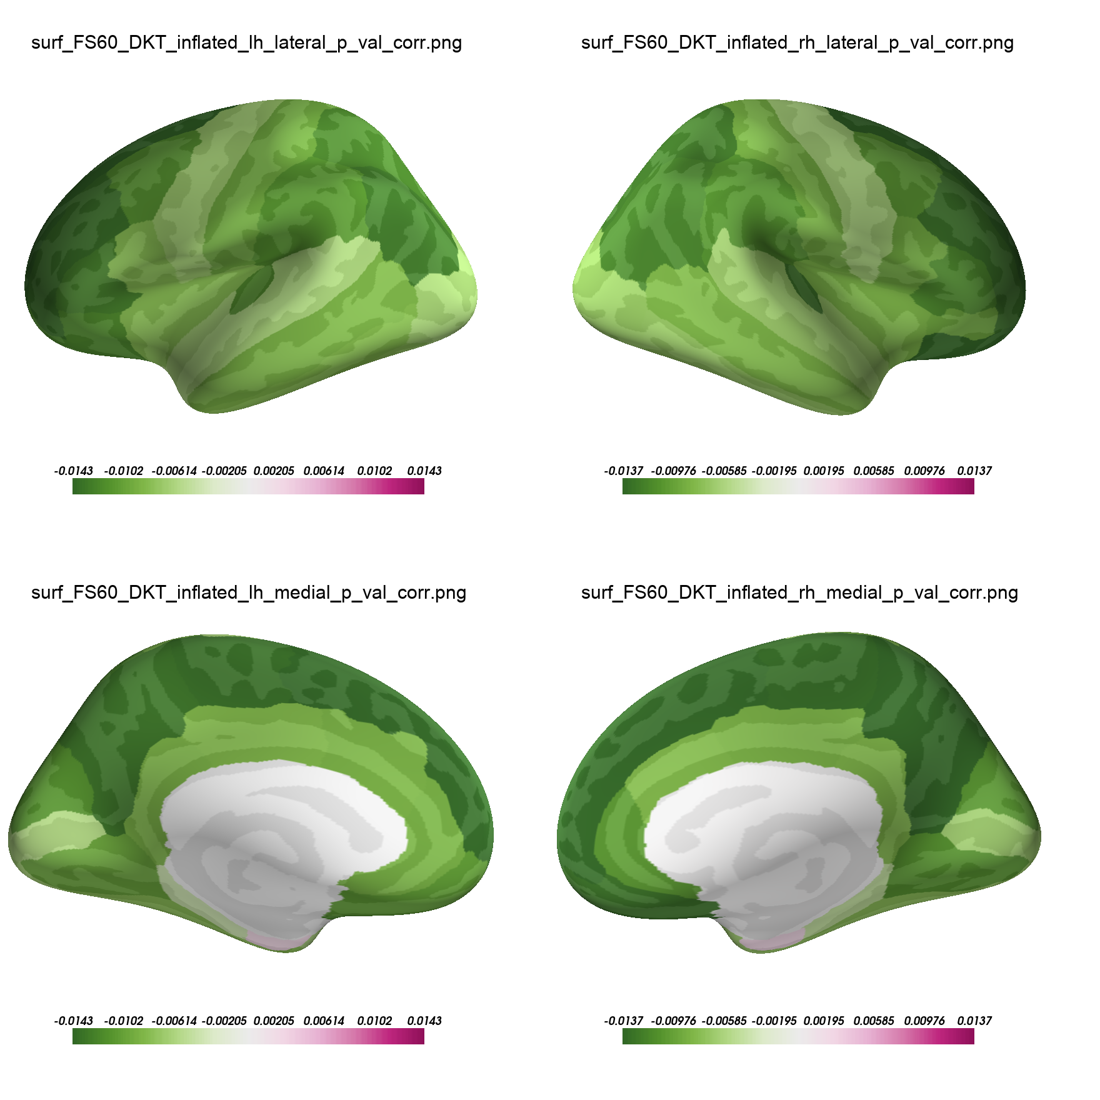

In [17]:
software = 'FS60'
qc = 'No_QC'
aparc = 'DKT'#'DKT' #'Destrieux' #'Glasser'
plot_dir = brainmaps_dir + brainmap_subdir_prefix + '{}_{}_{}/'.format(software, aparc, qc)
montage_im = createSingleImageMontage(plot_dir,thumb_size=500,font_size=30)

montage_dir = brainmaps_dir + 'atlas_AGE_AT_SCAN_ols_p_val_corr/montages/'
montage_im.save('{}{}_{}_{}.png'.format(montage_dir,software,qc,aparc),'png')

montage_im

### Aggregate results

## Simple ranking plot per atlas

In [68]:
roi_qc_df

qc,No_QC,manual_lenient,manual_stringent,auto_low_dim,auto_high_dim
roi,,,,,
L_EC_ROI,False,False,False,False,False
L_H_ROI,False,False,False,False,False
L_PHA1_ROI,False,False,False,False,False
L_STGa_ROI,False,False,False,False,False
L_TGv_ROI,False,False,False,False,False
R_EC_ROI,False,False,False,False,False
R_PHA1_ROI,False,False,False,False,False
R_PeEc_ROI,False,False,False,False,False
R_Pir_ROI,False,False,False,False,False



Aggregating QC perf for Glasser

 Number of signficant ROIs 360


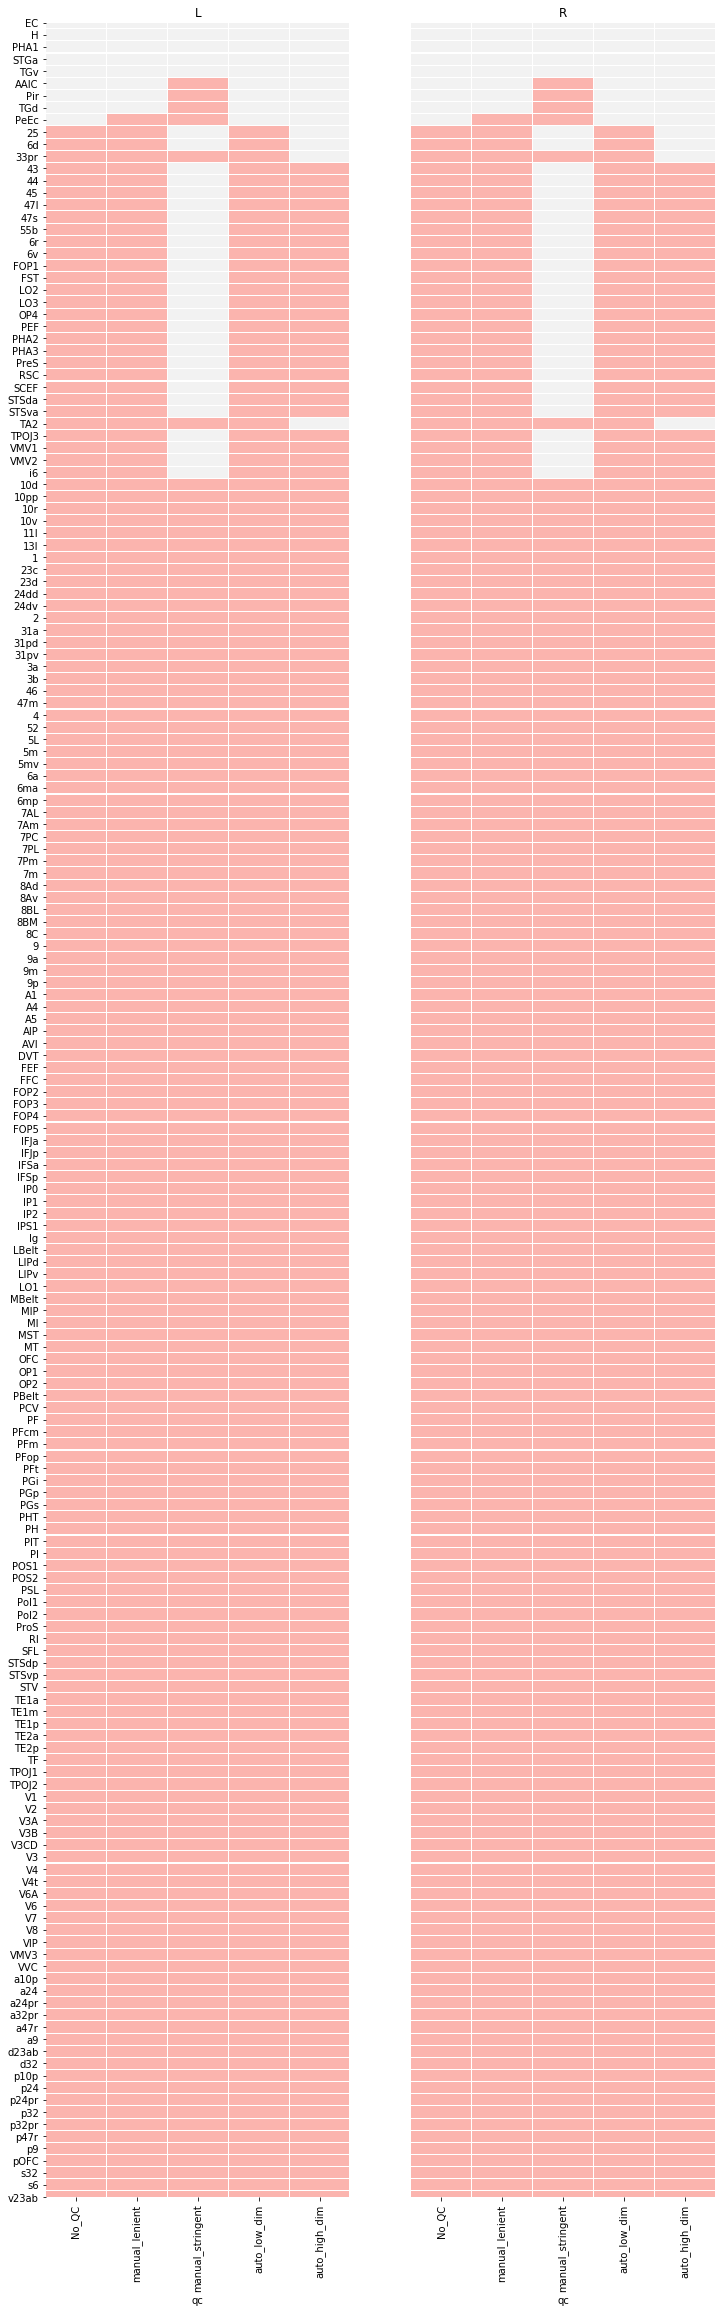

In [80]:

s = 0
software = 'FS60'

f, axes = plt.subplots(1,2,figsize=(12, 40),sharey=False,sharex=True)

for aparc in aparcs[2:3]:
    print('\nAggregating QC perf for {}'.format(aparc))
    save_dir = brainmaps_dir + brainmap_subdir_prefix + '/{}_{}_qc_agg/'.format(software,aparc)
    df_aparc_concat = pd.DataFrame()
    for qc in stat_perf_qc_concat.keys():
        df_aparc = stat_perf_qc_concat[qc][aparc]
        df_aparc['aparc'] = aparc
        df_aparc['qc'] = qc
        df_aparc_concat = df_aparc_concat.append(df_aparc)
        
    df_agg = aggregate_perf(df_aparc_concat,stat_measure,stat_thresh)
    agg_rois = df_agg['roi'].values
    agg_betas = df_agg['coef'].values
    print('\n Number of signficant ROIs {}'.format(len(agg_rois)))
    plot_regions_L,plot_regions_R,betas_L,betas_R = get_pysurfer_label_format(agg_rois,aparc,agg_betas)
    
    
    roi_order = df_agg.groupby(['roi']).sum().reset_index().sort_values(['rank','roi'])['roi'].values

    if aparc == 'Glasser':
        rois_L = [r for r in plot_regions_L]
        rois_R = [r for r in plot_regions_L]
        
    else:
        rois_L = ['L_{}'.format(r) for r in plot_regions_L]
        rois_R = ['R_{}'.format(r) for r in plot_regions_L]

    roi_order_L = [r for r in roi_order if r in rois_L]
    roi_order_R = [r for r in roi_order if r in rois_R]

    save_dir = brainmaps_dir + brainmap_subdir_prefix + '/{}_{}_qc_agg/'.format(software,aparc)
    a = df_aparc_concat[df_aparc_concat['aparc']==aparc].copy()
    a['significance'] = a[stat_measure] < stat_thresh
    roi_qc_df = a.pivot(index='roi',columns='qc',values='significance')
    
    roi_qc_df = roi_qc_df[['No_QC', 'maarten', 'gleb', 'auto_low_dim', 'auto_high_dim']]
    roi_qc_df = roi_qc_df.rename(columns={'maarten':'manual_lenient','gleb':'manual_stringent'})
    
    roi_qc_df = roi_qc_df.reindex(index = roi_order)
    roi_qc_df_L = roi_qc_df.loc[roi_order_L]
    roi_qc_df_R = roi_qc_df.loc[roi_order_R]
    
    # relabel index to drop hemi prefix
    if aparc == 'Glasser':             
        roi_qc_df_L.index = roi_qc_df_L.index.str.split('_',2,expand=True)
        roi_qc_df_L = roi_qc_df_L.droplevel([0,2])
        roi_qc_df_R.index = roi_qc_df_R.index.str.split('_',2,expand=True)
        roi_qc_df_R = roi_qc_df_R.droplevel([0,2])
    
    else:
        roi_qc_df_L.index = roi_qc_df_L.index.str.split('_',1,expand=True)
        roi_qc_df_L = roi_qc_df_L.droplevel([0])
        roi_qc_df_R.index = roi_qc_df_R.index.str.split('_',1,expand=True)
        roi_qc_df_R = roi_qc_df_R.droplevel([0])

    
    ax = axes[s]
    g = sns.heatmap(roi_qc_df_L,linewidths=0.05, cmap='Pastel1_r',ax=ax,cbar=False)    
    ax.set_title('L')
#     ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize=4)
    s = s + 1
    
    ax = axes[s]
    g = sns.heatmap(roi_qc_df_R,linewidths=0.05, cmap='Pastel1_r',ax=ax,cbar=False)    
    ax.set_title('R')
    ax.axes.yaxis.set_visible(False)
    s = s + 1

In [22]:
f, axes = plt.subplots(1,10,figsize=(15, 10),sharey='all',sharex=True)
f.tight_layout(pad=0, h_pad=0, w_pad=0)
roi_order = df_aparc_concat.groupby(['roi']).sum().reset_index().sort_values(['rank','roi'])['roi'].values

rois_L = ['L_{}'.format(r) for r in plot_regions_L]
rois_R = ['R_{}'.format(r) for r in plot_regions_L]

roi_order_L = [r for r in roi_order if r in rois_L]
roi_order_R = [r for r in roi_order if r in rois_R]

s = 0
software = 'FS60'
for aparc in df_aparc_concat['aparc'].unique():
    print('\nAggregating QC perf for {}'.format(aparc))
    save_dir = brainmaps_dir + brainmap_subdir_prefix + '/{}_{}_qc_agg/'.format(software,aparc)
    a = df_aparc_concat[df_aparc_concat['aparc']==aparc].copy()
    a['significance'] = a[stat_measure] < stat_thresh
    roi_qc_df = a.pivot(index='roi',columns='qc',values='significance')
    
    roi_qc_df = roi_qc_df[['No_QC', 'maarten', 'gleb', 'auto_low_dim', 'auto_high_dim']]
    roi_qc_df = roi_qc_df.rename(columns={'maarten':'manual_lenient','gleb':'manual_stringent'})
    
    roi_qc_df = roi_qc_df.reindex(index = roi_order)
    roi_qc_df_L = roi_qc_df.loc[roi_order_L]
    roi_qc_df_R = roi_qc_df.loc[roi_order_R]
    
    # relabel index to drop hemi prefix
    roi_qc_df_L.index = roi_qc_df_L.index.str.split('_',expand=True)
    roi_qc_df_L = roi_qc_df_L.droplevel([0])
    roi_qc_df_R.index = roi_qc_df_R.index.str.split('_',expand=True)
    roi_qc_df_R = roi_qc_df_R.droplevel([0])
    
    ax = axes[s]
    g = sns.heatmap(roi_qc_df_L,linewidths=0.05, cmap='Pastel1_r',ax=ax,cbar=False)    
#     ax.set_title('L')
    s = s + 1
    
    ax = axes[s]
    g = sns.heatmap(roi_qc_df_R,linewidths=0.05, cmap='Pastel1_r',ax=ax,cbar=False)    
#     ax.set_title('R')
    s = s + 1

,roi,coef,t_val,p_val,p_val_corr,aparc,qc
0,L_V1_ROI,-0.005436,-6.346670,3.299223e-10,4.366619e-10,Glasser,No_QC
1,L_MST_ROI,-0.010484,-8.551027,4.390388e-17,9.136068e-17,Glasser,No_QC
2,L_V6_ROI,-0.013045,-11.660317,1.371660e-29,7.964477e-29,Glasser,No_QC
3,L_V2_ROI,-0.008942,-11.240751,1.001597e-27,4.872633e-27,Glasser,No_QC
4,L_V3_ROI,-0.008706,-11.677421,1.148644e-29,6.887572e-29,Glasser,No_QC
5,L_V4_ROI,-0.008817,-11.508219,6.587849e-29,3.487685e-28,Glasser,No_QC
6,L_V8_ROI,-0.010141,-7.531396,1.099921e-13,1.767730e-13,Glasser,No_QC
7,L_4_ROI,-0.006658,-6.595880,6.763894e-11,9.188686e-11,Glasser,No_QC
8,L_3b_ROI,-0.006094,-7.796650,1.558276e-14,2.723202e-14,Glasser,No_QC
9,L_FEF_ROI,-0.009325,-8.090611,1.670046e-15,3.099055e-15,Glasser,No_QC


In [74]:
# w.r.t. QC for atlas
for aparc in aparcs:
    print('\nAggregating QC perf for {}'.format(aparc))
    save_dir = brainmaps_dir + brainmap_subdir_prefix + '/{}_{}_qc_agg/'.format(software,aparc)
    df_aparc_concat = pd.DataFrame()
    for qc in stat_perf_qc_concat.keys():
        df_aparc = stat_perf_qc_concat[qc][aparc]
        df_aparc['aparc'] = aparc
        df_aparc_concat = df_aparc_concat.append(df_aparc)
    
    if aparc == 'Glasser':
        aparc_file = '.HCP-MMP1.annot' 
    elif aparc == 'Destrieux':
        aparc_file = '.aparc.a2009s.annot' 
    elif aparc == 'aparc':
        aparc_file = '.aparc.annot'
    elif aparc in 'DKT':
        aparc_file = '.aparc.DKTatlas40.annot'
    else:
        aparc_file = ''
        print('Unknown cortical parcellation')
        
    df_agg = aggregate_perf(df_aparc_concat,stat_measure,stat_thresh)
    agg_rois = df_agg['roi'].values
    agg_betas = df_agg['rank'].values
    print('\n Number of signficant ROIs {}'.format(len(agg_rois)))
    plot_regions_L,plot_regions_R,betas_L,betas_R = get_pysurfer_label_format(agg_rois,aparc,agg_betas)
    #print('plot regions \nleft: {}, \nright: {}'.format(plot_regions_L,plot_regions_R))

    n_colors = 6 # for 0-5 QC ranks
    #cmap = plt.get_cmap('Blues',n_colors) #plt.get_cmap('Pastel1_r',n_colors) #plt.get_cmap('tab20b',n_colors) #sns.xkcd_palette(["very light pink",'red'])  #plt.get_cmap('Set1')
    cmap = plt.get_cmap('Reds',n_colors)
    plot_style = {'colormap':cmap,'range':[0,n_colors-1]}
    for hemi in ['lh','rh']:
        if hemi=='lh':
            signific_rois = plot_regions_L
            betas = betas_L
        elif hemi=='rh':
            signific_rois = plot_regions_R
            betas = betas_R
        else: 
            print('Unknown hemisphere parameter')

        for view in views:
            title = '_{}_{}_{}_{}_{}_{}_{}'.format('zagg',aparc,surf,hemi,view,stat_measure,software)
            brain_fig = create_surface_plot(common_space,hemi,surf,aparc_file,signific_rois,
                                            save_dir,title,view,betas,plot_style)
    
   
    


Aggregating QC perf for DKT

 Number of signficant ROIs 63
number of total vertices 163842 and ROIs 36
Using betas as colormap
number of significant rois 31
atlas: .aparc.DKTatlas40.annot, signficant roi count: {0.0: 14936, 3.0: 1608, 5.0: 147298}
colormap sequential: [0.00e+00, 2.50e+00, 5.00e+00] (opaque)
Image saved at /home/nikhil/projects/CT_reproduce/data/results/sm2/atlas/brainmaps/atlas_AGE_AT_SCAN_ols_p_val_corr//FS60_DKT_qc_agg/surf_zagg_DKT_inflated_lh_lateral_p_val_corr_FS60.png
number of total vertices 163842 and ROIs 36
Using betas as colormap
number of significant rois 31
atlas: .aparc.DKTatlas40.annot, signficant roi count: {0.0: 14936, 3.0: 1608, 5.0: 147298}
colormap sequential: [0.00e+00, 2.50e+00, 5.00e+00] (opaque)
Image saved at /home/nikhil/projects/CT_reproduce/data/results/sm2/atlas/brainmaps/atlas_AGE_AT_SCAN_ols_p_val_corr//FS60_DKT_qc_agg/surf_zagg_DKT_inflated_lh_medial_p_val_corr_FS60.png
number of total vertices 163842 and ROIs 36
Using betas as colormap

## Simple ranking plot per software

In [58]:
df_agg_concat = pd.DataFrame()
for software in stat_perf_qc_concat['software'].unique():
    print('\nAggregating QC perf for {}'.format(software))
    save_dir = brainmaps_dir + brainmap_subdir_prefix + '/{}_{}_qc_agg/'.format(software,aparc)
    a = stat_perf_qc_concat[stat_perf_qc_concat['software']==software].copy()
    df_agg = aggregate_perf(a,stat_measure,stat_thresh)
    df_agg['software'] = software
    df_agg_concat = df_agg_concat.append(df_agg)
    
    


Aggregating QC perf for ANTs

Aggregating QC perf for CIVET

Aggregating QC perf for FS5.1

Aggregating QC perf for FS5.3

Aggregating QC perf for FS6.0


In [150]:
roi_qc_df.columns

Index(['No_QC', 'auto_high_dim', 'auto_low_dim', 'gleb', 'maarten'], dtype='object', name='qc')

NameError: name 'df_agg_concat' is not defined

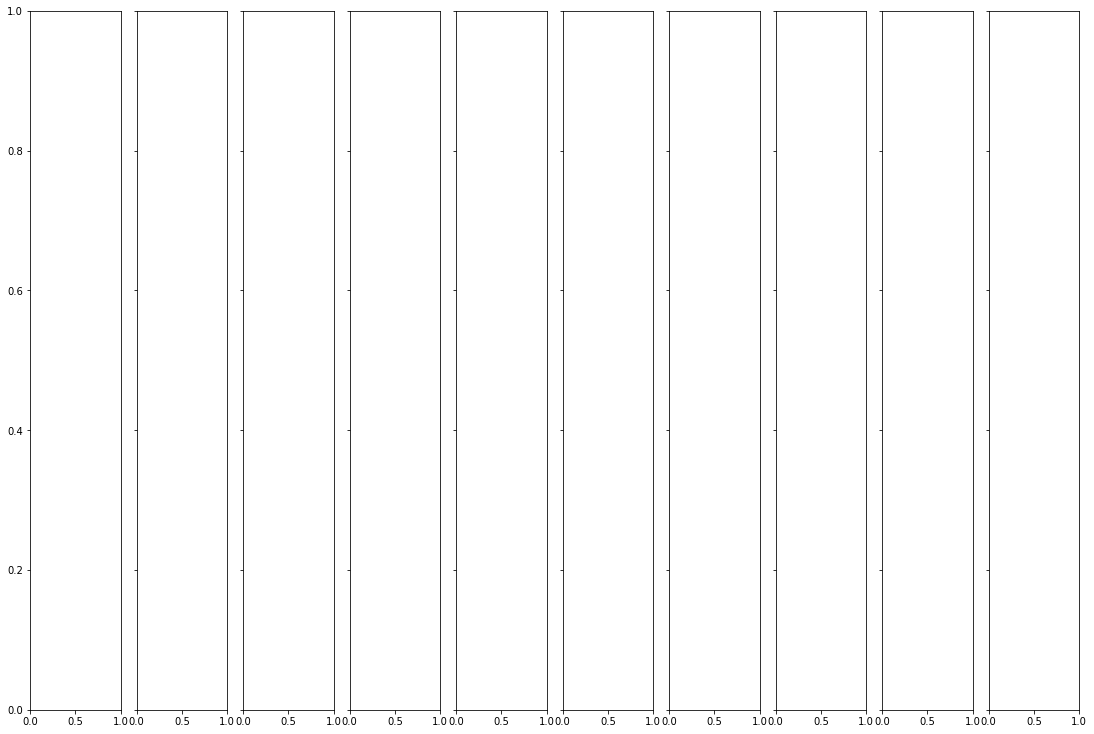

In [45]:
f, axes = plt.subplots(1,10,figsize=(15, 10),sharey='all',sharex=True)
f.tight_layout(pad=0, h_pad=0, w_pad=0)
roi_order = df_agg_concat.groupby(['roi']).sum().reset_index().sort_values(['rank','roi'])['roi'].values

rois_L = ['L_{}'.format(r) for r in plot_regions_L]
rois_R = ['R_{}'.format(r) for r in plot_regions_L]

roi_order_L = [r for r in roi_order if r in rois_L]
roi_order_R = [r for r in roi_order if r in rois_R]

s = 0
for software in stat_perf_qc_concat['software'].unique():
    print('\nAggregating QC perf for {}'.format(software))
    save_dir = brainmaps_dir + brainmap_subdir_prefix + '/{}_{}_qc_agg/'.format(software,aparc)
    a = stat_perf_qc_concat[stat_perf_qc_concat['software']==software].copy()
    a['significance'] = a[stat_measure] < stat_thresh
    roi_qc_df = a.pivot(index='roi',columns='qc',values='significance')
    
    roi_qc_df = roi_qc_df[['No_QC', 'maarten', 'gleb', 'auto_low_dim', 'auto_high_dim']]
    roi_qc_df = roi_qc_df.rename(columns={'maarten':'manual_lenient','gleb':'manual_stringent'})
    
    roi_qc_df = roi_qc_df.reindex(index = roi_order)
    roi_qc_df_L = roi_qc_df.loc[roi_order_L]
    roi_qc_df_R = roi_qc_df.loc[roi_order_R]
    
    # relabel index to drop hemi prefix
    roi_qc_df_L.index = roi_qc_df_L.index.str.split('_',expand=True)
    roi_qc_df_L = roi_qc_df_L.droplevel([0])
    roi_qc_df_R.index = roi_qc_df_R.index.str.split('_',expand=True)
    roi_qc_df_R = roi_qc_df_R.droplevel([0])
    
   
    
    ax = axes[s]
    g = sns.heatmap(roi_qc_df_L,linewidths=0.05, cmap='Pastel1_r',ax=ax,cbar=False)    
#     ax.set_title('L')
    s = s + 1
    
    ax = axes[s]
    g = sns.heatmap(roi_qc_df_R,linewidths=0.05, cmap='Pastel1_r',ax=ax,cbar=False)    
#     ax.set_title('R')
    s = s + 1

In [174]:
df_agg_concat_rank

,roi,rank,coef
3,L_entorhinal,8,0.002190
34,R_entorhinal,8,0.021819
15,L_parahippocampal,16,-0.029725
46,R_parahippocampal,16,-0.035732
31,R_caudalanteriorcingulate,18,-0.049238
7,L_insula,20,-0.050575
39,R_isthmuscingulate,20,-0.065784
4,L_fusiform,21,-0.053395
38,R_insula,21,-0.046585
55,R_rostralanteriorcingulate,21,-0.054942


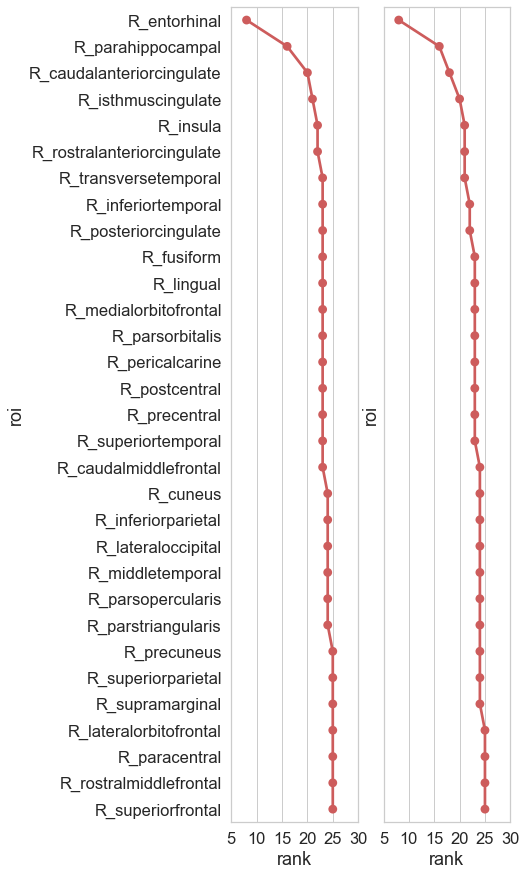

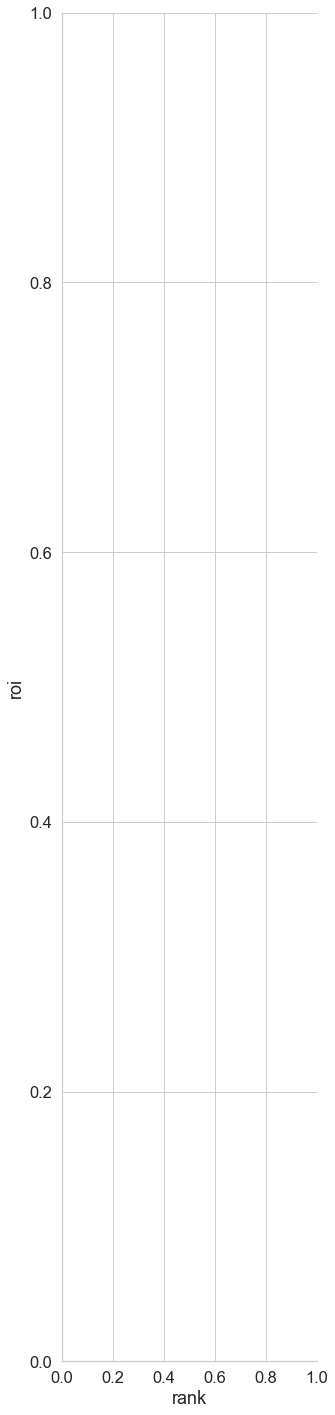

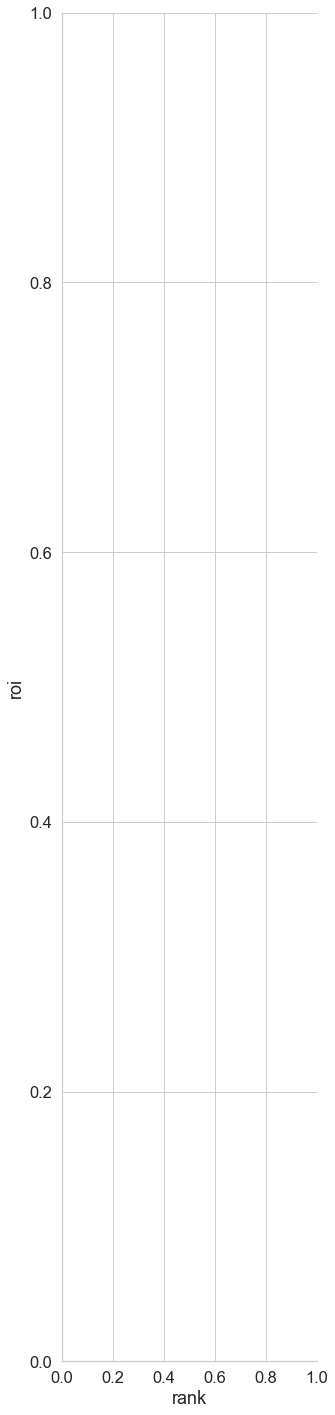

In [194]:
df_agg_concat_rank = df_agg_concat.groupby(['roi']).sum().reset_index().sort_values(['rank','roi'])

sns.set(font_scale=1.5)
with sns.axes_style("whitegrid"):
    f, axes = plt.subplots(1,2,figsize=(5, 15),sharey='all')
    plot_df = df_agg_concat_rank[df_agg_concat_rank['roi'].isin(rois_L)]
    g = sns.catplot(x='rank',y='roi',data=plot_df,kind='point',
                height=20,aspect=0.25,color='indianred',ax=axes[0])
    axes[0].set_xticks([5,10,15,20,25,30])
    
    plot_df = df_agg_concat_rank[df_agg_concat_rank['roi'].isin(rois_R)]
    g = sns.catplot(x='rank',y='roi',data=plot_df,kind='point',
                height=20,aspect=0.25,color='indianred',ax=axes[1])
    axes[1].set_xticks([5,10,15,20,25,30])

In [ ]:
# w.r.t. QC for software

for software in stat_perf_qc_concat['software'].unique():
    print('\nAggregating QC perf for {}'.format(software))
    save_dir = brainmaps_dir + brainmap_subdir_prefix + '/{}_{}_qc_agg/'.format(software,aparc)
    a = stat_perf_qc_concat[stat_perf_qc_concat['software']==software].copy()

    df_agg = aggregate_perf(a,stat_measure,stat_thresh)
    agg_rois = df_agg['roi'].values
    agg_betas = df_agg['rank'].values
    print('\n Number of signficant ROIs {}'.format(len(agg_rois)))
    plot_regions_L,plot_regions_R,betas_L,betas_R = get_pysurfer_label_format(agg_rois,aparc,agg_betas)
    #print('plot regions \nleft: {}, \nright: {}'.format(plot_regions_L,plot_regions_R))

    n_colors = 6 # for 0-5 QC ranks
    #cmap = plt.get_cmap('Blues',n_colors) #plt.get_cmap('Pastel1_r',n_colors) #plt.get_cmap('tab20b',n_colors) #sns.xkcd_palette(["very light pink",'red'])  #plt.get_cmap('Set1')
    cmap = plt.get_cmap('Reds',n_colors)
    plot_style = {'colormap':cmap,'range':[0,n_colors-1]}
    for hemi in ['lh','rh']:
        if hemi=='lh':
            signific_rois = plot_regions_L
            betas = betas_L
        elif hemi=='rh':
            signific_rois = plot_regions_R
            betas = betas_R
        else: 
            print('Unknown hemisphere parameter')

        for view in views:
            title = '_{}_{}_{}_{}_{}_{}_{}'.format('zagg',aparc,surf,hemi,view,stat_measure,software)
            brain_fig = create_surface_plot(common_space,hemi,surf,aparc_file,signific_rois,
                                            save_dir,title,view,betas,plot_style)

Reading images from /home/nikhil/projects/CT_reproduce/data/results/sm2/atlas/brainmaps/atlas_AGE_AT_SCAN_ols_p_val_corr/FS60_Destrieux_qc_agg/
Found 4 images
montage size (440, 440)


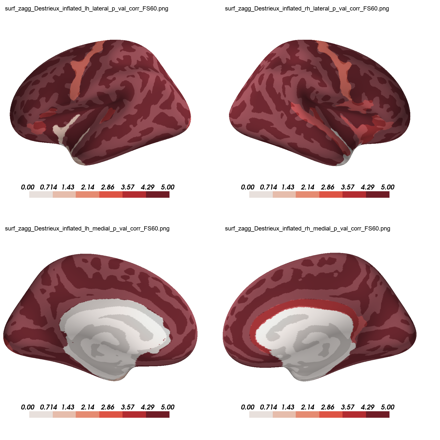

In [78]:
software = 'FS60'
aparc = 'Destrieux'#'DKT' #'Destrieux' #'Glasser'
plot_dir = brainmaps_dir + brainmap_subdir_prefix + '{}_{}_qc_agg/'.format(software,aparc)
montage_im = createSingleImageMontage(plot_dir)
montage_im

In [19]:
#w.r.t pipeline
if results_type == 'software':
    save_dir = brainmaps_dir + brainmap_subdir_prefix + '/software_agg/'
    ()
    stat_perf_software = stat_perf_qc_concat[stat_perf_qc_concat['qc']=='No_QC'].copy()

    df_agg = aggregate_perf(stat_perf_software,stat_measure,stat_thresh)
    
    agg_rois = df_agg['roi'].values
    agg_betas = df_agg['rank'].values
    print('\n Number of signficant ROIs {}'.format(len(agg_rois)))
    plot_regions_L,plot_regions_R,betas_L,betas_R = get_pysurfer_label_format(agg_rois,aparc,agg_betas)
    print('plot regions \nleft: {}, \nright: {}'.format(plot_regions_L,plot_regions_R))

    n_colors = 6 # for 0-5 ranks
    #cmap = plt.get_cmap('Blues',n_colors) #plt.get_cmap('Pastel1_r',n_colors) #plt.get_cmap('tab20b',n_colors) #sns.xkcd_palette(["very light pink",'red'])  #plt.get_cmap('Set1')
    cmap = plt.get_cmap('Reds',n_colors)
    plot_style = {'colormap':cmap,'range':[0,n_colors-1]}
    for hemi in ['lh','rh']:
        if hemi=='lh':
            signific_rois = plot_regions_L
            betas = betas_L
        elif hemi=='rh':
            signific_rois = plot_regions_R
            betas = betas_R
        else: 
            print('Unknown hemisphere parameter')

        for view in views:
            title = '_{}_{}_{}_{}_{}_{}'.format('zagg',aparc,surf,hemi,view,stat_measure)
            brain_fig = create_surface_plot(common_space,hemi,surf,aparc_file,signific_rois,
                                            save_dir,title,view,betas,plot_style)


 Number of signficant ROIs 62
plot regions 
left: ['cuneus', 'parahippocampal', 'caudalmiddlefrontal', 'insula', 'superiortemporal', 'inferiortemporal', 'lateraloccipital', 'medialorbitofrontal', 'parsopercularis', 'entorhinal', 'caudalanteriorcingulate', 'precuneus', 'isthmuscingulate', 'parstriangularis', 'fusiform', 'supramarginal', 'transversetemporal', 'parsorbitalis', 'middletemporal', 'pericalcarine', 'precentral', 'inferiorparietal', 'superiorparietal', 'lateralorbitofrontal', 'superiorfrontal', 'posteriorcingulate', 'paracentral', 'postcentral', 'rostralmiddlefrontal', 'rostralanteriorcingulate', 'lingual'], 
right: ['inferiortemporal', 'lateralorbitofrontal', 'insula', 'pericalcarine', 'precuneus', 'parstriangularis', 'isthmuscingulate', 'paracentral', 'lingual', 'fusiform', 'precentral', 'parahippocampal', 'superiorparietal', 'parsopercularis', 'medialorbitofrontal', 'middletemporal', 'cuneus', 'supramarginal', 'superiorfrontal', 'rostralmiddlefrontal', 'postcentral', 'ento

Reading images from /home/nikhil/projects/CT_reproduce/data/results/sm2/software/brainmaps/software_AGE_AT_SCAN_ols_p_val_corr//software_agg/
Found 4 images
montage size (440, 440)


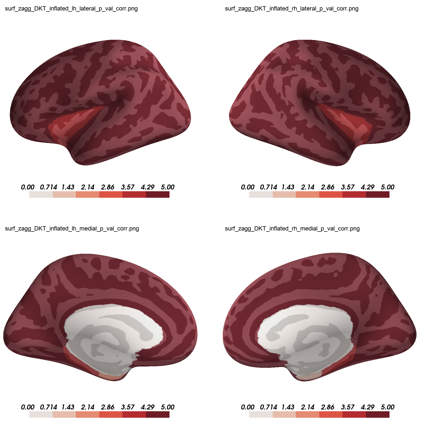

In [20]:
plot_dir = brainmaps_dir + brainmap_subdir_prefix + '/software_agg/'
montage_im = createSingleImageMontage(plot_dir)
montage_im

In [21]:
# w.r.t  QC and software
# w.r.t. QC

save_dir = brainmaps_dir + brainmap_subdir_prefix + '/qc_software_agg/'.format(software,aparc)

df_agg = aggregate_perf(stat_perf_qc_concat,stat_measure,stat_thresh)
agg_rois = df_agg['roi'].values
agg_betas = df_agg['rank'].values
print('\n Number of signficant ROIs {}'.format(len(agg_rois)))
plot_regions_L,plot_regions_R,betas_L,betas_R = get_pysurfer_label_format(agg_rois,aparc,agg_betas)
#print('plot regions \nleft: {}, \nright: {}'.format(plot_regions_L,plot_regions_R))

n_colors = 26 # for 0-5 QC and 0-5 software ranks
#cmap = plt.get_cmap('Blues',n_colors) #plt.get_cmap('Pastel1_r',n_colors) #plt.get_cmap('tab20b',n_colors) #sns.xkcd_palette(["very light pink",'red'])  #plt.get_cmap('Set1')
cmap = plt.get_cmap('Reds',n_colors)
plot_style = {'colormap':cmap,'range':[0,n_colors-1]}
for hemi in ['lh','rh']:
    if hemi=='lh':
        signific_rois = plot_regions_L
        betas = betas_L
    elif hemi=='rh':
        signific_rois = plot_regions_R
        betas = betas_R
    else: 
        print('Unknown hemisphere parameter')

    for view in views:
        title = '_{}_{}_{}_{}_{}_{}_{}'.format('zagg',aparc,surf,hemi,view,stat_measure,software)
        brain_fig = create_surface_plot(common_space,hemi,surf,aparc_file,signific_rois,
                                        save_dir,title,view,betas,plot_style)


 Number of signficant ROIs 62
number of total vertices 163842 and ROIs 36
Using betas as colormap
number of significant rois 31
atlas: .aparc.DKTatlas40.annot, signficant roi count: {0.0: 14125, 8.0: 811, 16.0: 1608, 20.0: 4791, 21.0: 4311, 22.0: 6536, 23.0: 52945, 24.0: 34455, 25.0: 44260}
colormap sequential: [0.00e+00, 1.25e+01, 2.50e+01] (opaque)
Image saved at /home/nikhil/projects/CT_reproduce/data/results/sm2/software/brainmaps/software_AGE_AT_SCAN_ols_p_val_corr//qc_software_agg/surf_zagg_DKT_inflated_lh_lateral_p_val_corr_ANTs.png
number of total vertices 163842 and ROIs 36
Using betas as colormap
number of significant rois 31
atlas: .aparc.DKTatlas40.annot, signficant roi count: {0.0: 14125, 8.0: 811, 16.0: 1608, 20.0: 4791, 21.0: 4311, 22.0: 6536, 23.0: 52945, 24.0: 34455, 25.0: 44260}
colormap sequential: [0.00e+00, 1.25e+01, 2.50e+01] (opaque)
Image saved at /home/nikhil/projects/CT_reproduce/data/results/sm2/software/brainmaps/software_AGE_AT_SCAN_ols_p_val_corr//qc_soft

Reading images from /home/nikhil/projects/CT_reproduce/data/results/sm2/brainmaps/Software_AGE_AT_SCAN_ols_p_val_corr//qc_software_agg/
Found 4 images
montage size (440, 440)


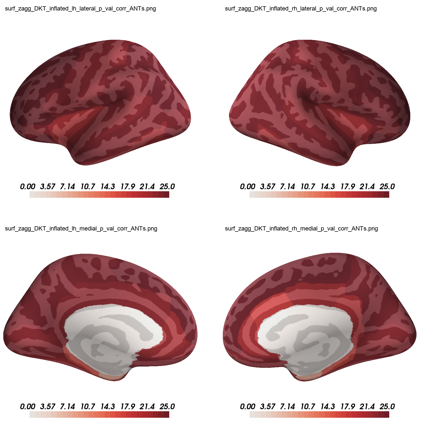

In [24]:
plot_dir = brainmaps_dir + brainmap_subdir_prefix + '/qc_software_agg/'
montage_im = createSingleImageMontage(plot_dir)
montage_im

(array([ 2.,  0.,  0.,  0.,  2.,  1.,  0.,  6., 24., 27.]),
 array([ 8. ,  9.7, 11.4, 13.1, 14.8, 16.5, 18.2, 19.9, 21.6, 23.3, 25. ]),
 <a list of 10 Patch objects>)

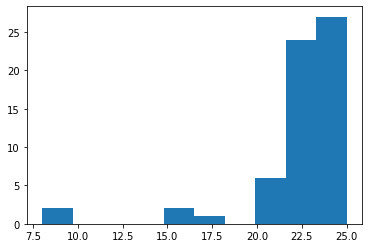

In [22]:
plt.hist(df_agg['rank'])